# 🐶 End-to-End Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TesnorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.
When I'm sitting at a cafe and I took a photo of a dog, I want to know what breed of a dog it is.

## 2. Data

The data we're using is from Kaggle's Dog Breed Identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images(unstructured data), so it's probably best we use deep learning/ transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are 10,000+ images in training set(these images have labels).
* There are 10,000+ images in test sest(these images do not have labels, bcz we're gonna predict them)


In [0]:
# Unzip the uploaded data into google drive
# !unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

### Get our workspace ready

* Import TensorFlow 2.0 ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

In [4]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF Version: " + tf.__version__)
print("TF HUB Version: " + hub.__version__)
# Check for GPU availability
print("GPU ", "available :) !!" if tf.config.list_physical_devices("GPU") else "not available :(")

TF Version: 2.2.0
TF HUB Version: 0.8.0
GPU  available :) !!


## Getting our data ready (turing into tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll all be doing first. Turning images into tensors(numerical representation).

Let's start by accessing the data and checking out the labels.

In [5]:
# Checkout the lables of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     05bac66dfae763fb86ab6360bd3c6f5f  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

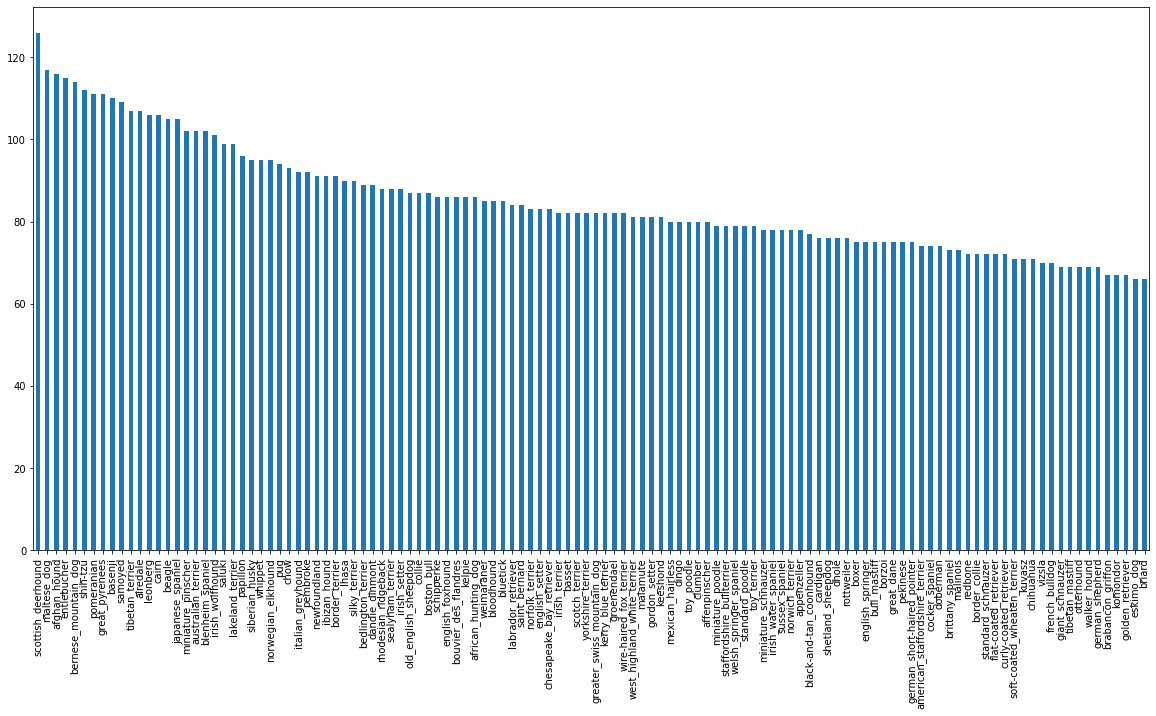

In [7]:
# How many images are there for each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [8]:
labels_csv["breed"].value_counts().median()

82.0

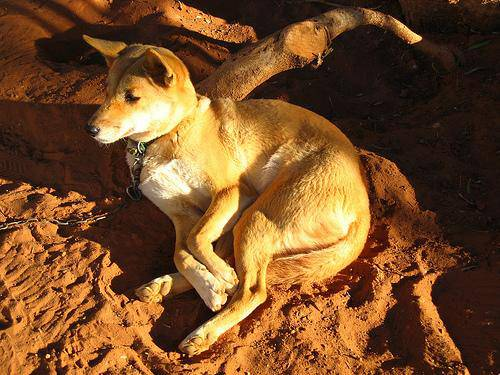

In [9]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their lables

Let's get the list of all image file pathnames.

In [10]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [11]:
# Create pathnames of Image ID's
filenames = ["drive/My Drive/Dog Vision/train/"+fname+".jpg" for fname in labels_csv["id"]]

filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
# Check whether number of file names matches number of actual image files
import os

if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames matched with the actual number of files!! Proceed.")
else:
  print("Filenames did not match the actual number of files. Please check the target directory.")

Filenames matched with the actual number of files!! Proceed.


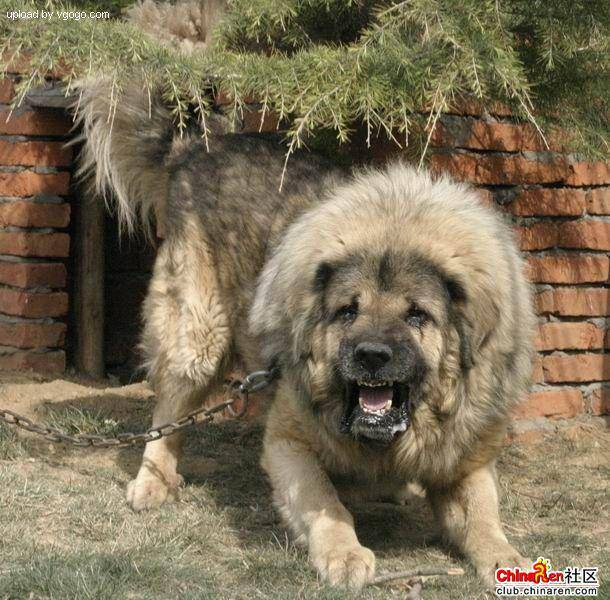

In [13]:
# One more check
Image(filenames[9000])

In [14]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [15]:
import numpy as np
labels = np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [16]:
len(labels)

10222

In [17]:
# See if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames !!")
else:
  print("Number of labels do not matche number of filenames, check the directories !")

Number of labels matches number of filenames !!


In [0]:
# Find the unique label values
unique_breeds = np.unique(labels)

In [19]:
len(unique_breeds)

120

In [20]:
# Turn single label into an array of booleans
labels[0] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [21]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [22]:
# Turn every label into boolean arrays
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
# Example turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be 1 wherer sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [24]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Creating our own validation set

Since the dataset does'nt come with validation set, we're going to create one.

In [0]:
# Setup X and y labels
X = filenames
y = boolean_labels

We're going to start off experiment with ~1000 images and increase as needed.

In [0]:
# Set the number of parameters to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:100}

In [27]:
# Let's split our data into training and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [28]:
# Let's have a look at the training data
X_train[:2], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

## Preprocessing images(turing images into Tensors)

To preprocess our images into Tensors we're going to write a function which does few things:
1. Take an image filepath as an input.
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into a Tensor.
4. Resize the `image` to a shape of (224 by 224)
4. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [29]:
# Convert image into NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [30]:
image.min(), image.max()

(0, 255)

In [31]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [32]:
# Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like in a Tensor, let's make a function to preprocess them.

1. Take an image filepath as an input.
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into a Tensor.
4. Normalize the image(convert colour channels from 0-255 to 0-1)
5. Resize the `image` to a shape of (224 by 224)
6. Return the modified `image`

In [0]:
# Define image size
IMG_SIZE = 224

def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg into numerical Tensor with 3 colour channesls (R,G,B)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (batch size) images at a time (you can manually adjust batch size if needed to be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`.

In [0]:
# Create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
  """
  Takes an image file path and an associated label,
  process the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [35]:
get_image_label(filenames[0], boolean_labels[0])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.5705322 , 0.33588538, 0.15008473],
         [0.66901225, 0.4601166 , 0.26022965],
         [0.61062384, 0.43763596, 0.21601713],
         ...,
         [0.8182312 , 0.7297958 , 0.26963907],
         [0.72454786, 0.6059109 , 0.2653059 ],
         [0.7494603 , 0.6252918 , 0.32456532]],
 
        [[0.6761415 , 0.4733761 , 0.30642927],
         [0.5672121 , 0.38192675, 0.20349538],
         [0.5883547 , 0.4322571 , 0.2403155 ],
         ...,
         [0.9326942 , 0.8260503 , 0.41093278],
         [0.86072475, 0.74250627, 0.3694122 ],
         [0.76781666, 0.6461604 , 0.29291284]],
 
        [[0.46350825, 0.29595745, 0.1536156 ],
         [0.42554107, 0.27039403, 0.12009468],
         [0.7887875 , 0.6547362 , 0.49015   ],
         ...,
         [0.89372385, 0.7696401 , 0.41811958],
         [0.88609535, 0.7585918 , 0.36495727],
         [0.8243601 , 0.69494826, 0.2930575 ]],
 
        ...,
 
        [[0.7344025 , 0.4716574 

Now we have got a way to turn our data into tuples of Tensors in the form: `(image, label)`. Let's make a function to turn all of our data (X & y) into batches!

In [0]:
# Define batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of images(X) and label(y) pairs.
  Shuffles data if it is training data but does'nt shuffle if it is validation data.
  Also accepts test data (no labels).
  """
  # If the data is test data, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only filepaths(no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is valid data, we don't need to shuffle it
  elif valid_data:
    print("Creating valid data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                              tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("Creating training data batches....")
    # Turn file paths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                              tf.constant(y))) # labels
    # Shuffling pathnames and labels before mapping image process funciton is much fastet than shuffling them after applying image process function.
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch


In [37]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches....
Creating valid data batches...


In [38]:
# Check different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches

Our data is in batches, however it id hard to understand/comprehend, let's vizualize them

In [0]:
import matplotlib.pyplot as plt

# Create a function for viewing images in data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(15,10))
  # Loop throuth 25 images (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [40]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

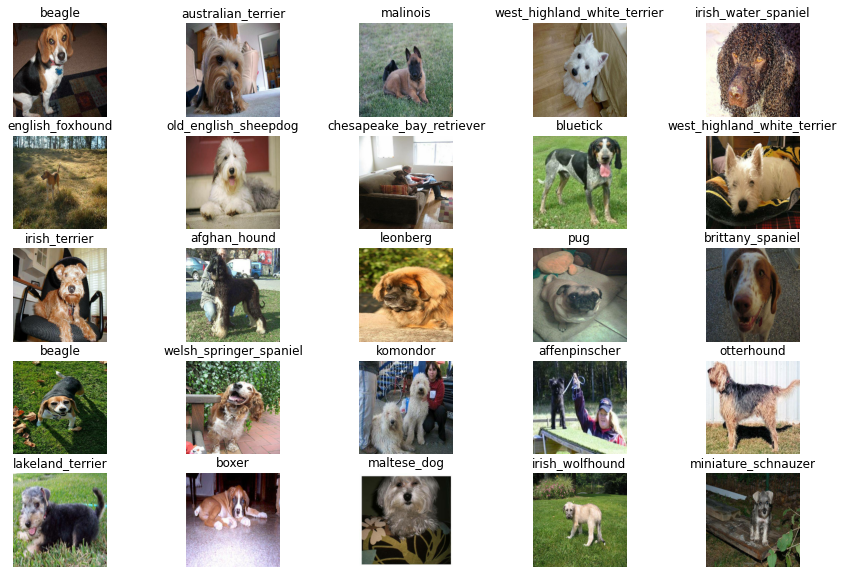

In [41]:
# Now let's vizualize the data in training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

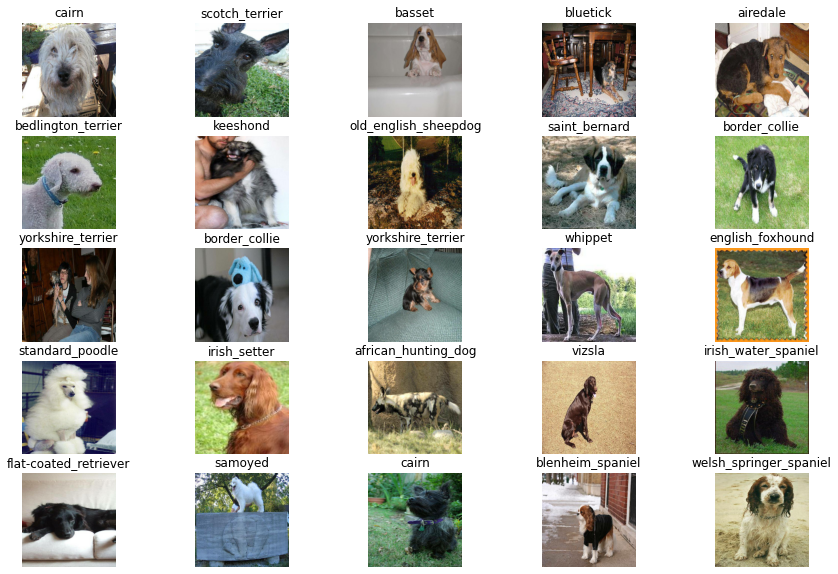

In [42]:
# Now let's visualize the validation batch
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model, there are few things we need to define:
* The input shape(our image shape, in the form of Tensors) to our model.
* The output shape(image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub:
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

* Takes the input shape, output shape and model we've chosen as parameters.
* Defines the layers in the Keras model in a sequential model(do this, then this, then that)
* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it will be getting)
* Returns the model.

All these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [0]:
# Create a model which builds Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: " + MODEL_URL)

  # Setup the layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 (Input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation="softmax") # Layer 2 (Output layer)
  ])

  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [45]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can do during training like:
* saving its progress,
* checking its progress,
* stop training early if a model stops improving, etc.

We'll create two callbacks, one for TensorBoard which helps us track our model progress and another for early stopping which prevents our model from training too long.

### Tensorboard callback

To setup a TesnorBoard callback, we need to do 3 things:

1. Load the TensorBoard notebook extension ✅
2. Create TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function. ✅
3. Vizualize the model's training logs with the %tensorboard magic function(we'll do this after the model training).

In [0]:
# Load TensorBoard notebook extesnion
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TesnorBoard callback
def create_tensorboard_callback():
  # Create log directory to save TesnorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so that the logs get tracked whenever we run an experimetn
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [0]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [50]:
# check to make we're still running on a GPU
print("GPU ", "available :) !!" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU  available :) !!


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup TensorBoard callback using `create_tensorboard_callback()`
* Call `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use.
* Return the model.

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create a new TensorBoard session every time we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # Return the fitted model
  return model

In [52]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 584s 23s/step - loss: 4.6044 - accuracy: 0.0913 - val_loss: 3.4672 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 4s 176ms/step - loss: 1.6484 - accuracy: 0.6900 - val_loss: 2.1954 - val_accuracy: 0.5050
Epoch 3/100
25/25 [==============================] - 4s 176ms/step - loss: 0.5694 - accuracy: 0.9475 - val_loss: 1.6859 - val_accuracy: 0.5600
Epoch 4/100
25/25 [==============================] - 4s 178ms/step - loss: 0.2486 - accuracy: 0.9875 - val_loss: 1.5095 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 4s 176ms/step - loss: 0.1441 - accuracy: 0.9987 - val_loss: 1.4316 - val_accuracy: 0.6300
Epoch 6/100
25/25 [==============================] - 4s 178ms/step - loss: 0.0993 - accuracy: 1.0000 - val_loss: 1.3863 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================

**Question:** It looks like our model is overfitting because it is performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks ?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access logs directory we created earlier and visualize its contents.

In [53]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

Output hidden; open in https://colab.research.google.com to view.

## Git commands to commit (this block of code is not revelant for project. Kindly ignore it.)

In [0]:
# !pwd

In [0]:
 cd drive/My\ Drive/Colab\ Notebooks

In [0]:
# !pwd

In [0]:
# !git status

In [0]:
# !git add .

In [0]:
# !git remote -v

In [0]:
# !git config --global user.email "bharatkammakatla@gmail.com"
# !git config --global user.name "BharatKammakatla"

In [0]:
# !git commit -m "Made initial predictions 1"

In [0]:
# !git push origin master

## Making and evalutaing predictions using trained model

In [63]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [64]:
# Make predictions on the validation data
predictions = model.predict(valid_data, verbose=1)
predictions

7/7 [==============================] - 1s 113ms/step


array([[4.6221269e-04, 4.7953756e-05, 1.3367484e-04, ..., 1.5912704e-04,
        9.7651719e-05, 1.4250705e-03],
       [7.0293905e-04, 4.6951981e-04, 6.9908733e-03, ..., 1.5066063e-04,
        2.5728252e-03, 2.5496804e-05],
       [1.7215296e-05, 6.0459389e-04, 3.0649728e-03, ..., 4.4332253e-05,
        1.3391019e-03, 1.6220319e-03],
       ...,
       [4.0903109e-05, 1.3119107e-05, 7.2612282e-05, ..., 1.6393004e-05,
        4.1401119e-04, 1.7646374e-04],
       [3.0804945e-03, 7.8339654e-04, 7.9874211e-05, ..., 7.3377829e-05,
        4.4487144e-05, 5.9805256e-03],
       [3.3976699e-04, 1.8789295e-05, 3.6639639e-04, ..., 4.1484330e-03,
        4.8772225e-04, 4.8951719e-05]], dtype=float32)

In [65]:
predictions.shape

(200, 120)

In [66]:
len(y_val)

200

In [67]:
len(unique_breeds)

120

In [68]:
predictions[0]

array([4.6221269e-04, 4.7953756e-05, 1.3367484e-04, 2.8260922e-05,
       4.1223667e-04, 1.6344658e-05, 1.3009844e-02, 9.9293294e-04,
       1.1701310e-04, 1.5016328e-04, 8.8055473e-04, 1.3539560e-04,
       6.9939982e-05, 3.9952360e-05, 1.5337039e-04, 5.0635543e-04,
       6.4267442e-05, 2.1136930e-02, 1.1837791e-05, 5.2884829e-05,
       3.8257340e-04, 1.4728359e-04, 1.9944189e-05, 1.8795499e-03,
       7.1927883e-05, 5.6145909e-05, 6.2635416e-01, 6.0018443e-05,
       1.9289200e-04, 1.0650781e-04, 5.7713285e-05, 7.5699855e-04,
       2.1506041e-04, 1.7844433e-05, 8.2873492e-05, 1.1260223e-02,
       8.0754406e-05, 1.1624242e-04, 3.4526060e-05, 8.5727326e-05,
       2.5174362e-04, 1.8045476e-04, 4.3234753e-04, 1.3807080e-04,
       1.7425467e-05, 1.0209243e-05, 1.0105194e-04, 2.8196286e-04,
       6.5763877e-04, 1.3549082e-04, 3.4075743e-04, 2.0081097e-04,
       1.8621035e-04, 3.9477069e-05, 1.7776637e-04, 1.6073436e-05,
       9.4505333e-05, 1.4520020e-03, 2.2464534e-04, 1.1688062e

In [69]:
len(predictions[0])

120

In [70]:
np.sum(predictions[0])

1.0

In [71]:
np.sum(predictions[1])

0.9999999

In [72]:
# First prediction
index = 42
print(predictions[index])
print(f"Max Value  (probability of prediction): {np.max(predictions[index])}")
print(f"Sum : {np.sum(predictions[index])}")
print(f"Max value's index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.21389916e-04 2.94669793e-04 9.13611730e-05 3.83725092e-05
 1.03219762e-03 3.01578722e-04 1.75339449e-03 3.80715705e-03
 2.00547092e-02 1.13864198e-01 1.79289018e-05 1.01509941e-04
 4.21950070e-04 8.64703208e-03 5.69905736e-04 6.74852356e-03
 2.78130083e-05 1.19717966e-03 1.01238278e-04 7.02274032e-04
 2.24028161e-04 4.15025279e-03 1.39072072e-04 4.00906647e-05
 5.76058263e-03 7.54998327e-05 4.86008357e-05 1.59199102e-04
 1.43699915e-04 1.55556700e-05 5.18632187e-05 1.02912611e-03
 1.09157467e-04 9.37034420e-05 2.29603884e-05 3.00956690e-05
 4.38090152e-04 2.96103943e-04 2.83962960e-04 2.51987487e-01
 1.97118832e-04 1.39301716e-04 5.57741709e-03 1.25805936e-05
 6.51869923e-04 1.48367952e-04 2.57531909e-04 9.19751823e-04
 1.31982830e-04 4.65817808e-04 2.18655186e-04 2.77098356e-04
 2.64642964e-04 5.49188675e-03 5.21791917e-05 1.27617223e-03
 1.20253372e-03 3.96647316e-04 2.02409938e-04 3.42321291e-05
 3.44591623e-04 7.39912561e-04 1.07225533e-05 9.59793615e-05
 7.78152025e-04 3.005927

Having the above functionality is great but we want to be able to do it at sclae.

And it would be even better if we could see the image the prediction is made on!

**Note:** Prediction probabilites are also known as confidence levels.

In [0]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns a given prediction probabilites array into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [77]:
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Now since our validation data in still in a batch dataset, we'll have to unbatch it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [78]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
# Create a function to unbatch a batch data_set
def unbatchify(dataset):
  """
  Takes a batched dataset of (images, labels) Tensors and returns separate arrays of images and labels.
  """

  images = []
  labels = []

  # Loop through batched data
  for image, label in dataset.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

In [0]:
# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)

In [101]:
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* prediction labels
* validation labels (truth labels)
* validation images

Let's make a function to make all these a bit more visual.

We'll create a function which:
* Takes and array of prediction probabilites, an array of truth labels, and an array of images and an integer.
* Convert the prediction probabilites into prediction labels.
* Plot the predicted label, its prediction probability, truth label and the target image on a single plot.

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View prediction, ground truth and image for sample n 
  """

  pred_prob, truth_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == truth_label:
    color = 'green'
  else:
    color = 'red'

  # Change plot title to be predicted, probability of predeiction, truth label 
  plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob)*100, truth_label), color = color)



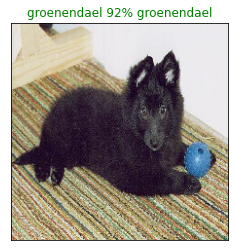

In [113]:
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=77)